# Assignment 2 - Question 4
The objective of this assignment is to get you familiarize with  the  problem  of  `Linear Regression`.

## Instructions
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells.
- No inbuilt functions to be used until specified

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>_Q4.ipynb`.
- Fill the Name and Roll number in the below markdown

Name: Anirudh Kaushik <br>
Roll Number: 2020111015

## Background about the dataset

TLDR: You have 4 independent variables (`float`) for each molecule. You can use a linear combination of these 4 independent variables to predict the bandgap (dependent variable) of each molecule.

You can read more about the problem in [Li et al, Bandgap tuning strategy by cations and halide ions of lead halide perovskites learned from machine learning, RSC Adv., 2021,11, 15688-15694](https://doi.org/10.1039/D1RA03117A).

In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all_molecules = list()

with open('bg_data.txt', 'r') as infile:
    input_rows = csv.DictReader(infile)
    
    for row in input_rows:
        current_mol = ([float(row['Cs']), float(row['FA']), float(row['Cl']), float(row['Br'])], float(row['Bandgap']))
        all_molecules.append(current_mol)

random.shuffle(all_molecules)


num_train = int(len(all_molecules) * 0.8)

# each point in x_train has 4 values - 1 for each feature
x_train = [x[0] for x in all_molecules[:num_train]]
# each point in y_train has 1 value - the bandgap of the molecule
y_train = [x[1] for x in all_molecules[:num_train]]

x_test = [x[0] for x in all_molecules[num_train:]]
y_test = [x[1] for x in all_molecules[num_train:]]

### 4.1 Implement a Linear Regression model that minimizes the MSE **without using any libraries**. You may use NumPy to vectorize your code, but *do not use numpy.polyfit* or anything similar.

4.1.1 Explain how you plan to implement Linear Regression in 5-10 lines.

<!-- your answer to 1.1.1 -->
#### 1.1.1
- In linear regression, we are given data points and we have to fit a hyperplane through them such that the distance between the hyperplane and that line is minimized.
- Unlike classification, in regression problems the outputs are real valued.
- We aim to find a linear relation between the independent variables (here it is the 4 dimensional vector x) and the dependent variable (here it is the one dimensional variable y containing the bandgap values)
##### Steps to implement linear regression
 - We initialize a weights array with dimension equal to the dimension of the independent vector x + 1, the extra dimension is because we add a bias term to make the model more flexible.
 - We define a linear layer which is of the form $y = W^T.X + b$. Here, b is the bias term, we append a constant 1.0 to the x vector before taking the dot product with the weights matrix to allow for the bias term.
 - We define the cost function, here we use mean squared error

   $Cost \ Function = \frac{1}{2}*||(y_{pred} - y_{actual})||^2$

 - We define the derivative of the cost function

    $ Derivative \ of \ the \ cost \ function =  (y_{pred} - y_{actual})$
 - In the forward pass, we calculate y_pred by applying the linear layer to each sample in X. We calculate MSE(y_pred, y).
 - In the backward pass we calculate the derivative of the loss function with respect to the weights vector using chain rule by calculating the derivative of the loss with respect to y_pred and multiplying that with derivative of y with respect to w ( which is simple the vector X + 1.0 (added for bias))
 - We sum over all the losses and divide by number of samples. Since this is batch gradient descent, for each epoch we calculate the mean of the derivative of loss function wrt W over all the samples and at the end update the weight vector by the rule $W^{(t+1)} = W^{(t)} - \eta*\frac{\delta J}{\delta W} $, where W is a vector.
 - We do this for around 800 epochs (hyperparameter) and after this we use the W obtained on the test set. 
 - Since we do not touch the test set while training, our results are valid.

4.1.2 Implement Linear Regression using `x_train` and `y_train` as the train dataset.

4.1.2.1 Choose the best learning rate and print the learning rate for which you achieved the best MSE.

In [3]:
def init(X): # get weight and bias matrix
    weights = np.zeros(X.shape[1] + 1) # dimension of x
    return weights

In [4]:
def linear_layer(x,W): # for a given training sample
   x = np.append(x,1)
   z = np.dot(x,W) # pre-activation 
   return z

In [5]:
def MSE(y_pred, y):
    return 0.5*((y_pred-y)**2)

In [6]:
def derivative_MSE(y_pred, y):
    return (y_pred - y)

In [7]:
def forward_pass(x,W):
    y = linear_layer(x,W) # linear output
    return y

In [8]:
def backward_pass(x,y,y_pred):
    der_y_J = derivative_MSE(y_pred,y) # derivative of loss wrt y
    der_w_y =  np.array([x[0], x[1],x[2],x[3], 1.0]) # derivative of z wrt w
    der_w_J = der_y_J * der_w_y# derivative of loss wrt w
    
    return der_w_J


for learning_rate: 0.001 MSE: 0.37579 standard derviation of squared error: 0.57329
for learning_rate: 0.01 MSE: 0.05295 standard derviation of squared error: 0.10343
for learning_rate: 0.05 MSE: 0.00363 standard derviation of squared error: 0.00658
for learning_rate: 0.1 MSE: 0.00108 standard derviation of squared error: 0.00144
for learning_rate: 0.5 MSE: 0.00088 standard derviation of squared error: 0.00126
for learning_rate: 1 MSE: 0.00088 standard derviation of squared error: 0.00126


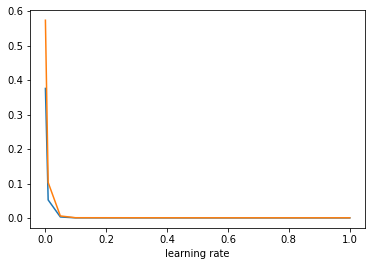

In [9]:
def model(x_train,y_train,x_test,y_test,learning_rate=0.001,epochs=100):
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    W = init(x_train)
    num_samples = x_train.shape[0]
    for epoch in range(epochs):
        der_w_Err = 0
        for i in range(len(x_train)): # for all training samples
            y_pred = forward_pass(x_train[i],W)
            der_w_J = backward_pass(x_train[i],y_train[i],y_pred)
            der_w_Err += der_w_J/num_samples
        # update
        W = W - learning_rate*der_w_Err
    # test
    Y = []
    error_lis = []
    for i in range(len(x_test)):
        y_pred = forward_pass(x_test[i],W)
        Y.append(y_pred)
        error_lis.append(MSE(y_pred, y_test[i]))
    error_lis = np.array(error_lis)
    avg_mse,std_mse = round(np.mean(error_lis),5), round(np.std(error_lis),5)
    print(f"for learning_rate: {learning_rate} MSE: {avg_mse} standard derviation of squared error: {std_mse}")
    return W, Y, avg_mse,std_mse
lr = [0.001,0.01,0.05,0.1,0.5,1]
avg_mse_lis = []
std_mse_lis = []
y_pred_lis = []
for learning_rate in lr:
    W, y_pred, avg_mse,std_mse = model(x_train,y_train,x_test,y_test,learning_rate=learning_rate,epochs=800)
    y_pred_lis.append(y_pred)
    avg_mse_lis.append(avg_mse)
    std_mse_lis.append(std_mse)
plt.xlabel('learning rate')
plt.plot(lr,avg_mse_lis, label="MSE")
plt.plot(lr,std_mse_lis, label="STD of squared error")

plt.show()

In [10]:
ind = avg_mse_lis.index(min(avg_mse_lis))
y_pred = y_pred_lis[ind]
print(f"Minimum MSE obtained for learning_rate: {lr[ind]}")
for i,j in list(zip(y_pred,y_test)):
    print(f"predicted: {round(i,2)} gnd_truth: {j}")

Minimum MSE obtained for learning_rate: 0.5
predicted: 1.82 gnd_truth: 1.81
predicted: 1.61 gnd_truth: 1.65
predicted: 1.63 gnd_truth: 1.63
predicted: 1.56 gnd_truth: 1.52
predicted: 1.81 gnd_truth: 1.8
predicted: 1.55 gnd_truth: 1.48
predicted: 1.64 gnd_truth: 1.62
predicted: 1.71 gnd_truth: 1.75
predicted: 1.58 gnd_truth: 1.56
predicted: 2.86 gnd_truth: 2.84
predicted: 1.6 gnd_truth: 1.61
predicted: 3.07 gnd_truth: 3.13
predicted: 1.65 gnd_truth: 1.69
predicted: 1.69 gnd_truth: 1.69
predicted: 2.2 gnd_truth: 2.23
predicted: 1.92 gnd_truth: 1.96
predicted: 2.96 gnd_truth: 2.98
predicted: 1.49 gnd_truth: 1.52
predicted: 3.02 gnd_truth: 3.0
predicted: 2.2 gnd_truth: 2.3
predicted: 1.84 gnd_truth: 1.75
predicted: 1.78 gnd_truth: 1.76


4.1.3 Make a [Parity Plot](https://en.wikipedia.org/wiki/Parity_plot) of your model's bandgap predictions on the test set with the actual values.

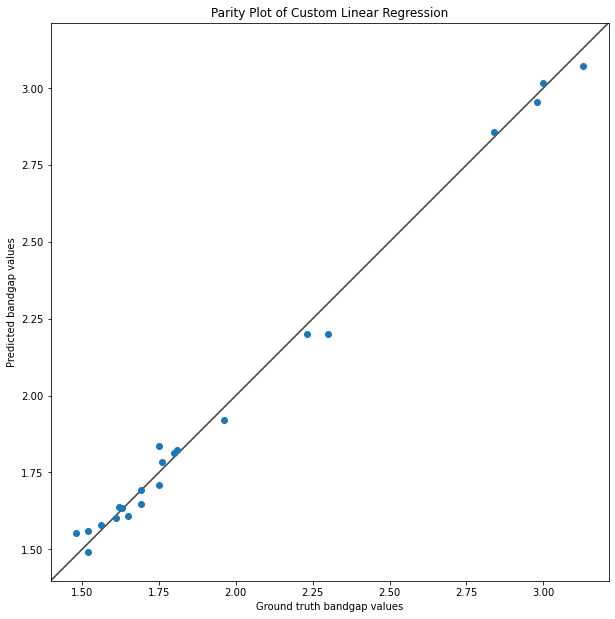

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,20))

ax.scatter(y_test, y_pred)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_title('Parity Plot of Custom Linear Regression')
ax.set_xlabel('Ground truth bandgap values')
ax.set_ylabel('Predicted bandgap values')
plt.show()

### 4.2 Implement Ridge regression
4.2.1 Explain Ridge regression briefly in 1-2 lines.

<!-- Your answer to 1.2.1 -->
#### 1.2.1
 - Ridge regression is a model tuning method for estimating coefficients of multiple-regression models when data suffers from multi-collinearity, i.e., two or more independent variables in a model are correlated. We perform L2 regularization.
 - In multicollinearity least squares are unbiased and variances are large leading to large differences between predicted and actual values.
 - A ridge regression estimator is used to provide a more precise ridge parameters estimate, as its variance and mean square estimator are often smaller than the least square estimators.
 
 $Cost \ function: Min(||Y – X(\theta)||^2 + \alpha||\theta||^2)$

4.2.2 Implement Ridge regression and make a table of different RMSE scores you achieved with different values of alpha. What does the parameter `alpha` do? How does it affect the results here? Explain in 5-10 lines in total. (You can use scikit-learn from this cell onwards)

In [12]:
# you should not have imported sklearn before this point
import pandas as pd
import sklearn
from sklearn.linear_model import Ridge
import numpy as np
alpha = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0]
mean_res = []

for a in alpha:
    clf = Ridge(alpha=a)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    mse_lis = 0
    for i,j in list(zip(y_pred, y_test)):
        mse_lis += 2*MSE(i,j)

    mean_res.append(np.sqrt(mse_lis/len(y_test)))
df = pd.DataFrame({'Alpha':alpha, "RMSE score": mean_res})
display(df)
# implement Ridge regression and make a table where you explore the effect of different values of `alpha`

,Alpha,RMSE score
0,0.00,0.041972
1,0.01,0.042159
2,0.05,0.043317
3,0.10,0.045558
4,0.50,0.076809
5,1.00,0.117243
6,5.00,0.277152
7,10.00,0.347808
8,50.00,0.462136


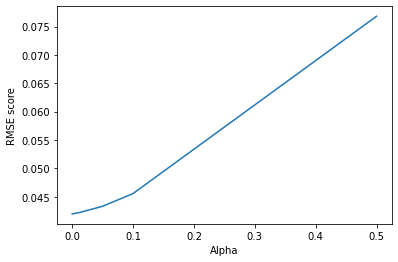

In [13]:
plt.xlabel('Alpha')
plt.ylabel('RMSE score')
plt.plot(alpha[0:5], mean_res[0:5])
plt.show()

#### Q. What does the parameter alpha do? How does it affect the results here? Explain in 5-10 lines in total.
#### Answer:
- $\alpha$ is the penalty term. Higher values of $\alpha$ imposes a greater penalty thus reducing the magnitude of the coefficients.
- It reduces multicollinearity or correlation between the independent variables of the model by shrinking the parameters
- The coefficient shrinking reduces the model complexity 
- $\alpha$ is a constant that multiplies the L2 term, controlling regularization strength. 
- $\alpha$ must be non-negative
- With $\alpha =  0$, the model is equivalent to ordinary least squares linear regression.

### 4.3 Implement Lasso regression
4.3.1 Explain Lasso regression briefly in 1-2 lines.
- LASSO stands for least absolute shrinkage and selection operator. Lasso regression is also a regularization technique. The main difference between ridge and lasso regression is that lasso regression uses L1 regularization while ridge regression uses L2 regularization. 
- WShrinkage is where data values are shrunk towards a central point as the mean. The lasso procedure encourages simple, sparse models (i.e. models with fewer parameters). 
- Suitable for models with high levels of multicollinearity.
- Lasso forces the sum of the absolute value of the regression coefficients to be less than a fixed value, which forces certain coefficients to zero, excluding them from impacting prediction. This idea is similar to ridge regression, which also shrinks the size of the coefficients; however, ridge regression does not set coefficients to zero (and, thus, does not perform variable selection).

  $ Cost \ Function: (\frac{1}{(2 * n_samples)}) * ||y - Xw||^2_2 + \alpha * ||w||_1$

- Lasso Regression uses L1 regularization technique and automatically performs feauture selection as described above.

4.3.2 Implement Lasso regression and make a table of different RMSE scores you achieved with different values of alpha. What does the parameter `alpha` do? How does it affect the results here? Explain in 5-10 lines in total.

In [14]:
import pandas as pd
import sklearn
from sklearn.linear_model import Lasso
import numpy as np
alpha = [ 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0]
mean_res = []

for a in alpha:
    clf = Lasso(alpha=a)
    clf.fit(x_train, y_train) 
    y_pred = clf.predict(x_test)
    mse_lis = 0
    for i,j in list(zip(y_pred, y_test)):
        mse_lis += 2*MSE(i,j)
    mean_res.append(np.sqrt(mse_lis/len(y_test)))
df = pd.DataFrame({'Alpha':alpha, "RMSE score": mean_res})
display(df)
# implement Lasso regression and make a table where you explore the effect of different values of `alpha`

,Alpha,RMSE score
0,0.01,0.085229
1,0.05,0.327081
2,0.10,0.521230
3,0.50,0.522405
4,1.00,0.522405
5,5.00,0.522405
6,10.00,0.522405
7,50.00,0.522405


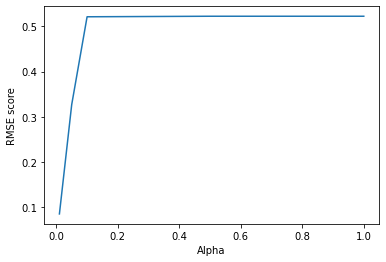

In [15]:
plt.xlabel('Alpha')
plt.ylabel('RMSE score')
plt.plot(alpha[0:5], mean_res[0:5])
plt.show()

#### Q. What does the parameter alpha do? How does it affect the results here?
#### Answer:
- $\alpha$ is a constant that multiplies the L1 term, controlling regularization strength
- It denotes amount of shrinkage.
- Setting $\alpha$ to $\infty$ means maximum shrinkage, i.e., no parameter is considered and all are set to 0. No features are selected
- The bias increases with increase in $\alpha$
- Variance increases with decrease in $\alpha$
- $\alpha$ must be non-negative
- With $\alpha =  0$, the model is equivalent to ordinary least squares linear regression.